# Philips Supplier Sustainability Analytics - Starter Notebook

This notebook provides a minimal starting point for the assignment.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Load Data

In [2]:
# Load the data
df = pd.read_excel('data/SSP_Data.xlsx')

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"Number of unique suppliers: {df['ID'].nunique()}")
df.head()

Dataset shape: (1262, 495)
Number of unique suppliers: 463


,Index,ID,Sequence,Assessment Year,Assessment type,Country,Val_Score,Val_Environment,Val_Health and Safety,Val_Business Ethics,...,Q953_3,Q953_4,Q953_5,Q1443,Q1446,Q1449,Q1450,Q954,Q956,Q1452
0,256-1,256,1,2017,DV - Desktop Validation,China,0.67175,0.7110,0.7614,0.694,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,256-2,256,2,2018,SA - Site Assessment,China,0.73240,0.8800,0.7210,0.721,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,256-3,256,3,2019,SA - Site Assessment,China,0.71215,0.8250,0.6536,0.721,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,256-4,256,4,2020,DV - Desktop Validation,China,0.76200,0.8550,0.7140,0.800,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,745-1,745,1,2019,SA - Site Assessment,Indonesia,0.56180,0.8336,0.4546,0.355,...,1.0,0.0,0.0,0.0,NaN,NaN,0.0,1.0,1.0,1.0


## 3. Data Preparation

We prepare the dataset in clear steps: identify target fields, isolate General Information (GI) features, and build encoded matrices that respect supplier-level splits. The following cells document every transformation so the reasoning stays transparent.

In [3]:
from pathlib import Path
from typing import Dict, Tuple

# Paths and constants stay centralized so adjustments are painless later on.
DATA_PATH = Path("data/SSP_Data.xlsx")
ID_COLUMN = "ID"
TARGET_COLUMN = "Val_Score"
BIC_THRESHOLD = 0.75  # Philips guidance for Best-in-Class segmentation.
MAX_MISSING_RATE = 0.95  # Drop features that are more than 95% missing to avoid noise.

# Load the full dataset once. We keep a copy that will remain untouched for reference so we can always audit assumptions.
raw_df = pd.read_excel(DATA_PATH, sheet_name="Data")
raw_df.set_index("Index", inplace=True)  # Keep Philips' composite key handy without polluting features downstream.

# --- General Information (GI) selection rules ---
# GI features combine Activities, Facilities, Workforce counts, and simple categorical descriptors.
# The assignment notes 31 GI attributes. We explicitly document the range we use and how we reach 31.
GI_RANGE_START = "Activities - Raw material extraction"
GI_RANGE_END = "Number of workers - Indirect employed"
gi_block = list(raw_df.loc[:, GI_RANGE_START:GI_RANGE_END].columns)
GI_CATEGORICAL = ["Country", "Assessment type", "Assessment Year"]  # Added to reach the 31-feature target (28 + 3).
GI_FEATURES = GI_CATEGORICAL + gi_block

# SAQ questions are coded as Q####. They supply the richer questionnaire-based features for stage 2.
SAQ_FEATURES = [col for col in raw_df.columns if col.startswith("Q")]

# A quick sanity check keeps future debugging inexpensive.
print(f"GI feature count: {len(GI_FEATURES)}")
print(f"SAQ feature count: {len(SAQ_FEATURES)}")

# Helper dictionary keeps feature sets tidy for later loops.
FEATURE_SETS: Dict[str, Dict[str, object]] = {
    "gi_only": {
        "features": GI_FEATURES,
        "description": "Activities, facilities, workforce, and basic categorical context.",
    },
    "gi_plus_saq": {
        "features": GI_FEATURES + SAQ_FEATURES,
        "description": "Full GI set augmented with all SAQ responses.",
    },
}
# Features with excessive missingness are filtered in the bundle assembly step so reporting stays transparent.



GI feature count: 31
SAQ feature count: 450


### Missingness Audit

Before modeling it helps to quantify sparse features. The next cell calculates per-feature missing rates so we can judge whether imputation plus missing flags is reasonable or if any columns should be dropped entirely. Columns with over 95% missingness will be automatically excluded from the modeling pipelines.


In [4]:
def compute_missing_rates(df: pd.DataFrame, columns: list, label: str, top_n: int = 10) -> pd.DataFrame:
    """Return a sorted table of missing-value percentages for the requested columns."""
    rates = (
        df[columns]
        .isna()
        .mean()
        .sort_values(ascending=False)
        .head(top_n)
        .rename("missing_rate")
        .to_frame()
    )
    rates["feature_set"] = label
    return rates

missing_gi = compute_missing_rates(raw_df, GI_FEATURES, "gi_only", top_n=10)
missing_gi_plus = compute_missing_rates(raw_df, GI_FEATURES + SAQ_FEATURES, "gi_plus_saq", top_n=10)

missing_summary = pd.concat([missing_gi, missing_gi_plus])
missing_summary


,missing_rate,feature_set
Activities - Testing and measurement,0.858954,gi_only
Number of workers - Indirect employed,0.858162,gi_only
Activities - Surface treatment / plating,0.858162,gi_only
Activities - Silkscreen / pad printing,0.858162,gi_only
Activities - Packaging (cardboard / colorbox / pulp tray / label / blister),0.858162,gi_only
Facilities - Kitchen,0.005547,gi_only
Facilities - Canteen,0.005547,gi_only
Facilities - Dormitory on site or employer provided accommodation close to the site,0.005547,gi_only
Facilities - Power generation,0.004754,gi_only
Facilities - Hospital / infirmary,0.003962,gi_only


/var/folders/zq/3v8lrf3100d27kbnsrqrgl800000gn/T/ipykernel_93726/2747496582.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/zq/3v8lrf3100d27kbnsrqrgl800000gn/T/ipykernel_93726/2747496582.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


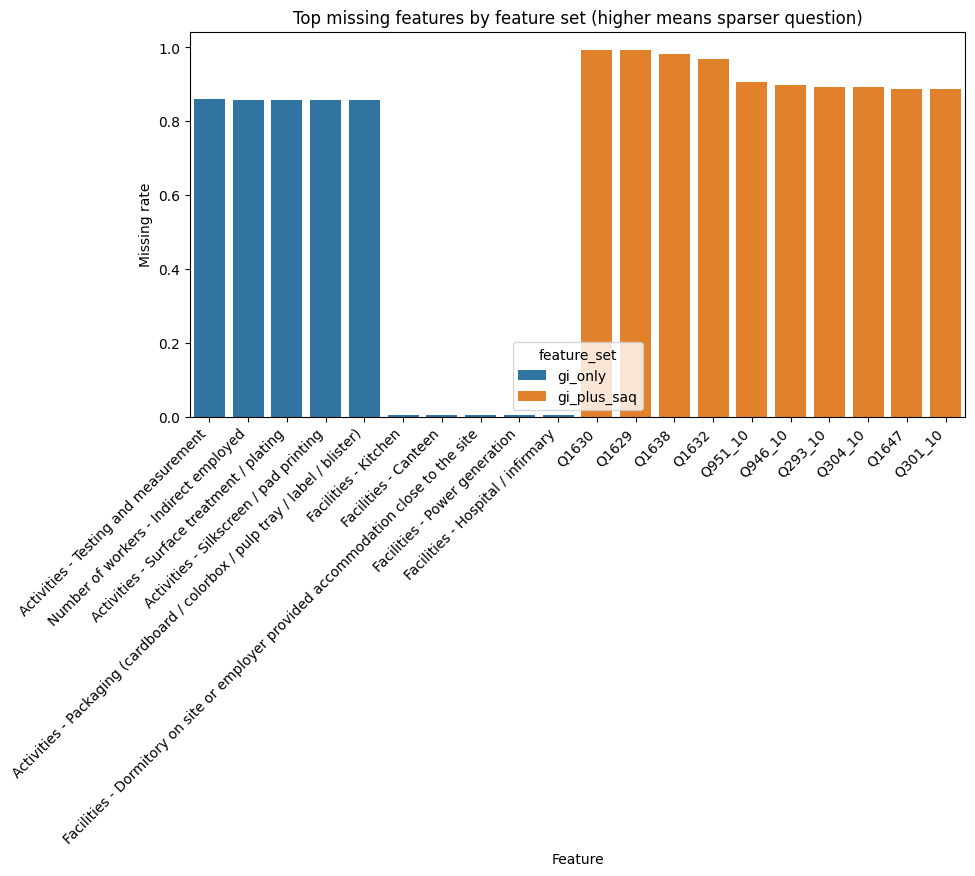

In [5]:
# Visualize the sparsest features so stakeholders see which questions are rarely answered.
missing_plot_data = (
    missing_summary.reset_index()
    .rename(columns={"index": "feature"})
    .sort_values(["feature_set", "missing_rate"], ascending=[True, False])
)

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=missing_plot_data,
    x="feature",
    y="missing_rate",
    hue="feature_set",
)
ax.set_title("Top missing features by feature set (higher means sparser question)")
ax.set_ylabel("Missing rate")
ax.set_xlabel("Feature")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()



### Target Distribution Check

Visualizing the validated sustainability score helps confirm there is enough variation for regression and how the BIC threshold splits the population.


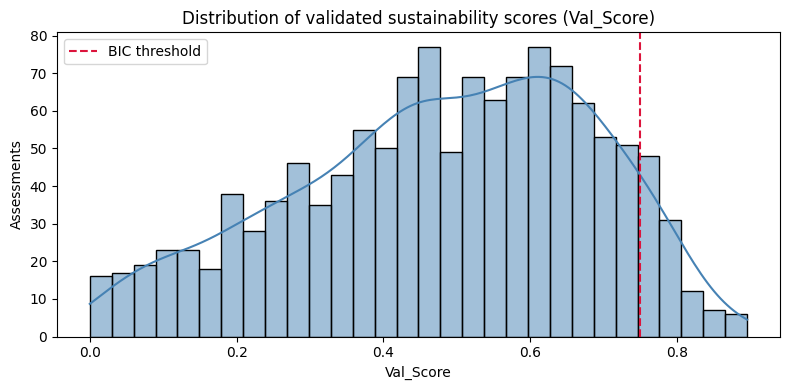

In [6]:
plt.figure(figsize=(8, 4))
ax = sns.histplot(raw_df[TARGET_COLUMN].dropna(), bins=30, kde=True, color="steelblue")
ax.axvline(BIC_THRESHOLD, color="crimson", linestyle="--", label="BIC threshold")
ax.set_title("Distribution of validated sustainability scores (Val_Score)")
ax.set_xlabel("Val_Score")
ax.set_ylabel("Assessments")
ax.legend()
plt.tight_layout()
plt.show()



In [7]:
from sklearn.model_selection import GroupShuffleSplit

missing_score_count = raw_df[TARGET_COLUMN].isna().sum()
missing_country_count = raw_df.dropna(subset=[TARGET_COLUMN])["Country"].isna().sum()

# Drop rows lacking a validated sustainability score. Keeping NaNs would poison supervised learning.
# This only removes assessments where Philips never confirmed the evidence, preventing unreliable training labels.
model_df = raw_df.dropna(subset=[TARGET_COLUMN]).copy()

# Binary label for the classification task: Best-in-Class (BIC) vs Room-for-Improvement (RFI).
# Following Philips guidance we flag BIC when the validated overall score exceeds 0.75.
model_df["is_bic"] = (model_df[TARGET_COLUMN] >= BIC_THRESHOLD).astype(int)

# Ensure we only keep suppliers with a defined country to avoid empty categories after encoding.
# A "missing country" category would blur geography effects and muddy fairness checks, so we require an explicit value.
model_df = model_df.dropna(subset=["Country"])

print(
    f"Dropped {missing_score_count} assessments without validated scores and "
    f"{missing_country_count} assessments without country information."
)

# Supplier-aware split: hold out 20% of suppliers for final testing.
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(splitter.split(model_df, groups=model_df[ID_COLUMN]))
train_df = model_df.iloc[train_idx].copy()
test_df = model_df.iloc[test_idx].copy()

print(f"Training supplier count: {train_df[ID_COLUMN].nunique()}")
print(f"Testing supplier count: {test_df[ID_COLUMN].nunique()}")
print(f"Training rows: {train_df.shape[0]}, Testing rows: {test_df.shape[0]}")


Dropped 0 assessments without validated scores and 0 assessments without country information.
Training supplier count: 370
Testing supplier count: 93
Training rows: 978, Testing rows: 284


## 4. Feature Engineering Pipelines

Next we codify reusable preprocessing so each model consumes the same cleaned matrices. Numeric columns get median imputation with explicit missing flags and standardization, while categorical flags receive safe one-hot encodings.


In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


def build_preprocessor(df: pd.DataFrame, feature_list: list) -> Tuple[ColumnTransformer, list, list]:
    """Create the preprocessing pipeline for the provided feature subset."""
    # Identify categorical features via dtype inspection to keep logic maintainable.
    categorical = [col for col in feature_list if df[col].dtype == "object"]
    numeric = [col for col in feature_list if col not in categorical]

    # Numeric pipeline adds explicit missingness indicators before scaling.
    numeric_pipeline = Pipeline(
        steps=[
            ("impute", SimpleImputer(strategy="median", add_indicator=True)),
            ("scale", StandardScaler()),
        ]
    )

    # Categorical pipeline sticks to interpretable one-hot encodings.
    categorical_pipeline = Pipeline(
        steps=[
            ("impute", SimpleImputer(strategy="most_frequent")),
            (
                "encode",
                OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            ),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("numeric", numeric_pipeline, numeric),
            ("categorical", categorical_pipeline, categorical),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )

    return preprocessor, numeric, categorical



In [9]:
feature_bundles: Dict[str, Dict[str, object]] = {}

for key, meta in FEATURE_SETS.items():
    feature_list = meta["features"]

    # Remove features that are almost entirely missing to keep noise out of the models.
    missing_rates = train_df[feature_list].isna().mean()
    filtered_features = missing_rates[missing_rates <= MAX_MISSING_RATE].index.tolist()
    dropped_features = sorted(set(feature_list) - set(filtered_features))
    if dropped_features:
        print(f"{key}: dropped {len(dropped_features)} high-missing features (>{MAX_MISSING_RATE:.0%} NaN)")

    preprocessor, numeric_cols, categorical_cols = build_preprocessor(train_df, filtered_features)

    feature_bundles[key] = {
        "meta": meta,
        "preprocessor": preprocessor,
        "numeric_cols": numeric_cols,
        "categorical_cols": categorical_cols,
        "filtered_features": filtered_features,
        "dropped_features": dropped_features,
        "X_train": train_df[filtered_features],
        "X_test": test_df[filtered_features],
        "y_train_reg": train_df[TARGET_COLUMN],
        "y_test_reg": test_df[TARGET_COLUMN],
        "y_train_clf": train_df["is_bic"],
        "y_test_clf": test_df["is_bic"],
    }

print("Prepared bundles:")
for bundle_name, bundle in feature_bundles.items():
    print(f"- {bundle_name}: {bundle['X_train'].shape[1]} raw features after filtering")


gi_plus_saq: dropped 4 high-missing features (>95% NaN)
Prepared bundles:
- gi_only: 31 raw features after filtering
- gi_plus_saq: 477 raw features after filtering


### Performance Comparison Charts (moved)

These charts are consolidated and recomputed after the stratified split near the end of the notebook under "Consolidated Performance Charts (Post-Refresh)" to avoid duplication and stale variables.


In [10]:
# Deprecated: charts moved to consolidated section to ensure they use refreshed splits/models.
print("Skipping here: see 'Consolidated Performance Charts (Post-Refresh)' below.")


Skipping here: see 'Consolidated Performance Charts (Post-Refresh)' below.


## 5. Baseline Metrics

Simple baselines set the reference point. We track mean-prediction RMSE/MAE for regression and majority-class accuracy/AUC for classification.


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, roc_auc_score
import numpy as np

baseline_results = {}

for key, bundle in feature_bundles.items():
    y_train_reg = bundle["y_train_reg"]
    y_test_reg = bundle["y_test_reg"]
    y_train_clf = bundle["y_train_clf"]
    y_test_clf = bundle["y_test_clf"]

    reg_pred = np.full_like(y_test_reg, fill_value=y_train_reg.mean(), dtype=float)
    mse = mean_squared_error(y_test_reg, reg_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_reg, reg_pred)

    majority_label = int(y_train_clf.mode()[0])
    clf_pred = np.full_like(y_test_clf, fill_value=majority_label)
    accuracy = accuracy_score(y_test_clf, clf_pred)
    try:
        auc = roc_auc_score(y_test_clf, clf_pred)
    except ValueError:
        auc = 0.5  # When only one class is present in test data, default to random performance.

    baseline_results[key] = {
        "rmse": rmse,
        "mae": mae,
        "accuracy": accuracy,
        "roc_auc": auc,
        "mean_target": y_train_reg.mean(),
        "majority_label": majority_label,
    }

baseline_df = pd.DataFrame(baseline_results).T
baseline_df


,rmse,mae,accuracy,roc_auc,mean_target,majority_label
gi_only,0.198011,0.164175,0.883803,0.5,0.471684,0.0
gi_plus_saq,0.198011,0.164175,0.883803,0.5,0.471684,0.0


## 6. Model Training & Evaluation

We fit one linear and one tree-based model per task and feature set. Pipelines keep preprocessing consistent, and we benchmark each model against the baselines captured earlier.


In [12]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, precision_recall_fscore_support

model_results = []
model_registry: Dict[str, Pipeline] = {}

for feature_key, bundle in feature_bundles.items():
    preprocessor = bundle["preprocessor"]

    regressors = {
        "ridge": Ridge(alpha=1.0),
        "random_forest": RandomForestRegressor(
            n_estimators=300,
            random_state=42,
            n_jobs=-1,
            max_depth=None,
        ),
    }

    classifiers = {
        "logistic_regression": LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            solver="lbfgs",
        ),
        "random_forest": RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            n_jobs=-1,
        ),
    }

    # Regression loop
    for model_name, reg_model in regressors.items():
        pipeline = Pipeline(steps=[("prep", preprocessor), ("model", reg_model)])
        pipeline.fit(bundle["X_train"], bundle["y_train_reg"])
        predictions = pipeline.predict(bundle["X_test"])

        mse = mean_squared_error(bundle["y_test_reg"], predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(bundle["y_test_reg"], predictions)
        r2 = r2_score(bundle["y_test_reg"], predictions)

        model_key = f"{feature_key}__regression__{model_name}"
        model_registry[model_key] = pipeline

        model_results.append(
            {
                "feature_set": feature_key,
                "task": "regression",
                "model": model_name,
                "rmse": rmse,
                "mae": mae,
                "r2": r2,
                "rmse_gain_vs_baseline": baseline_results[feature_key]["rmse"] - rmse,
                "mae_gain_vs_baseline": baseline_results[feature_key]["mae"] - mae,
            }
        )

    # Classification loop
    for model_name, clf_model in classifiers.items():
        pipeline = Pipeline(steps=[("prep", preprocessor), ("model", clf_model)])
        pipeline.fit(bundle["X_train"], bundle["y_train_clf"])
        class_predictions = pipeline.predict(bundle["X_test"])
        prob_predictions = pipeline.predict_proba(bundle["X_test"])[:, 1]

        accuracy = accuracy_score(bundle["y_test_clf"], class_predictions)
        auc = roc_auc_score(bundle["y_test_clf"], prob_predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(
            bundle["y_test_clf"], class_predictions, average="binary"
        )

        model_key = f"{feature_key}__classification__{model_name}"
        model_registry[model_key] = pipeline

        model_results.append(
            {
                "feature_set": feature_key,
                "task": "classification",
                "model": model_name,
                "accuracy": accuracy,
                "roc_auc": auc,
                "precision": precision,
                "recall": recall,
                "f1": f1,
                "accuracy_gain_vs_baseline": accuracy - baseline_results[feature_key]["accuracy"],
                "auc_gain_vs_baseline": auc - baseline_results[feature_key]["roc_auc"],
            }
        )

model_results_df = pd.DataFrame(model_results)
model_results_df


,feature_set,task,model,rmse,mae,r2,rmse_gain_vs_baseline,mae_gain_vs_baseline,accuracy,roc_auc,precision,recall,f1,accuracy_gain_vs_baseline,auc_gain_vs_baseline
0,gi_only,regression,ridge,0.172827,0.141189,0.213874,0.025184,0.022985,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,gi_only,regression,random_forest,0.170986,0.139931,0.230528,0.027024,0.024243,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,gi_only,classification,logistic_regression,NaN,NaN,NaN,NaN,NaN,0.795775,0.771097,0.318841,0.666667,0.431373,-0.088028,0.271097
3,gi_only,classification,random_forest,NaN,NaN,NaN,NaN,NaN,0.894366,0.775746,1.000000,0.090909,0.166667,0.010563,0.275746
4,gi_plus_saq,regression,ridge,0.422956,0.308226,-3.708244,-0.224945,-0.144051,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,gi_plus_saq,regression,random_forest,0.145222,0.119221,0.444948,0.052789,0.044954,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,gi_plus_saq,classification,logistic_regression,NaN,NaN,NaN,NaN,NaN,0.876761,0.865266,0.466667,0.424242,0.444444,-0.007042,0.365266
7,gi_plus_saq,classification,random_forest,NaN,NaN,NaN,NaN,NaN,0.887324,0.912834,0.666667,0.060606,0.111111,0.003521,0.412834


In [13]:
# Separate tables for quick inspection
regression_summary = model_results_df[model_results_df["task"] == "regression"].sort_values(
    ["feature_set", "rmse"]
)
classification_summary = model_results_df[model_results_df["task"] == "classification"].sort_values(
    ["feature_set", "roc_auc"], ascending=[True, False]
)

regression_summary, classification_summary


(   feature_set        task          model      rmse       mae        r2  \
 1      gi_only  regression  random_forest  0.170986  0.139931  0.230528   
 0      gi_only  regression          ridge  0.172827  0.141189  0.213874   
 5  gi_plus_saq  regression  random_forest  0.145222  0.119221  0.444948   
 4  gi_plus_saq  regression          ridge  0.422956  0.308226 -3.708244   
 
    rmse_gain_vs_baseline  mae_gain_vs_baseline  accuracy  roc_auc  precision  \
 1               0.027024              0.024243       NaN      NaN        NaN   
 0               0.025184              0.022985       NaN      NaN        NaN   
 5               0.052789              0.044954       NaN      NaN        NaN   
 4              -0.224945             -0.144051       NaN      NaN        NaN   
 
    recall  f1  accuracy_gain_vs_baseline  auc_gain_vs_baseline  
 1     NaN NaN                        NaN                   NaN  
 0     NaN NaN                        NaN                   NaN  
 5     NaN Na

In [14]:
column_meta = pd.read_excel(DATA_PATH, sheet_name="Column Explanation")
column_meta["Column header"] = column_meta["Column header"].astype(str)
COLUMN_TOPIC_LOOKUP = (
    column_meta.set_index("Column header")["Topic"].fillna("-").to_dict()
)
COLUMN_CHAPTER_LOOKUP = (
    column_meta.set_index("Column header")["Chapter"].fillna("-").to_dict()
)

print("Loaded column metadata for interpretability mapping.")


Loaded column metadata for interpretability mapping.


### Risk Tier Visualization

Plotting tier counts helps explain workload implications to program managers.


In [15]:
try:
    _ = risk_assessment
except NameError:
    print("Skipping here: risk tiers rendered after the stratified refresh section.")
else:
    try:
    _ = risk_assessment
except NameError:
    print("Skipping here: risk tiers rendered after the stratified refresh section.")
else:
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(
        data=risk_assessment,
        x="risk_tier",
        order=["Critical Risk", "High Risk", "Medium Risk", "Moderate Risk", "Low Risk"],
        palette="flare",
    )
    ax.set_title("Predicted risk tiers across held-out suppliers")
    ax.set_xlabel("Risk tier")
    ax.set_ylabel("Supplier assessments")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()



IndentationError: expected an indented block after 'try' statement on line 6 (2654335102.py, line 7)

## 7. Interpretability Insights

We extract global and local explanations for the strongest GI and GI+SAQ models. Global scores rely on SHAP for tree-based estimators and coefficient magnitudes for linear models. Local explanations highlight one high-performing and one low-performing supplier.


### Fairness Guardrail Plot

Visualizing false negative rates by region makes the guardrail easier to interpret in the memo.


In [ ]:
fnr_plot_data = fnr_by_region.reset_index().rename(columns={"fnr": "false_negative_rate"})

plt.figure(figsize=(5, 4))
ax = sns.barplot(
    data=fnr_plot_data,
    x="region_group",
    y="false_negative_rate",
    palette="crest",
)
ax.set_ylim(0, 1)
ax.set_title("False negative rate by region")
ax.set_xlabel("Region group")
ax.set_ylabel("False negative rate (missed BIC suppliers)")
plt.tight_layout()
plt.show()



NameError: name 'fnr_by_region' is not defined

### SHAP Importance Charts

Bar charts summarise the top drivers so we can drop them straight into the appendix.


In [ ]:
for feature_set, shap_table in shap_results.items():
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(
        data=shap_table.sort_values("mean_abs_shap", ascending=False),
        x="mean_abs_shap",
        y="feature",
        color="teal",
    )
    ax.set_title(f"Top SHAP drivers for {feature_set} model")
    ax.set_xlabel("Mean |SHAP value|")
    ax.set_ylabel("Feature")
    plt.tight_layout()
    plt.show()



NameError: name 'shap_results' is not defined

In [ ]:
best_model_selection = {}

for feature_set in FEATURE_SETS.keys():
    reg_subset = regression_summary[regression_summary["feature_set"] == feature_set]
    best_reg = reg_subset.loc[regression_summary[regression_summary["feature_set"] == feature_set]["rmse"].idxmin()]
    best_model_selection[(feature_set, "regression")] = best_reg["model"]

    clf_subset = classification_summary[classification_summary["feature_set"] == feature_set]
    best_clf = clf_subset.loc[classification_summary[classification_summary["feature_set"] == feature_set]["roc_auc"].idxmax()]
    best_model_selection[(feature_set, "classification")] = best_clf["model"]

best_model_selection


{('gi_only', 'regression'): 'random_forest',
 ('gi_only', 'classification'): 'random_forest',
 ('gi_plus_saq', 'regression'): 'random_forest',
 ('gi_plus_saq', 'classification'): 'random_forest'}

In [ ]:
import shap

shap_results = {}

for feature_set in FEATURE_SETS.keys():
    rf_key = f"{feature_set}__regression__random_forest"
    if rf_key not in model_registry:
        continue

    pipeline = model_registry[rf_key]
    bundle = feature_bundles[feature_set]
    X_sample = bundle["X_train"].sample(n=min(300, len(bundle["X_train"])) , random_state=42)

    transformer = pipeline.named_steps["prep"]
    model = pipeline.named_steps["model"]

    transformed = transformer.transform(X_sample)
    feature_names = transformer.get_feature_names_out()

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(transformed)
    mean_abs_shap = np.abs(shap_values).mean(axis=0)

    shap_df = (
        pd.DataFrame(
            {
                "feature": feature_names,
                "mean_abs_shap": mean_abs_shap,
            }
        )
        .sort_values("mean_abs_shap", ascending=False)
        .head(15)
    )

    # Attach chapter/topic metadata for richer interpretation.
    shap_df["chapter"] = shap_df["feature"].map(COLUMN_CHAPTER_LOOKUP)
    shap_df["topic"] = shap_df["feature"].map(COLUMN_TOPIC_LOOKUP)

    shap_results[feature_set] = shap_df

shap_results


{'gi_only':                                               feature  mean_abs_shap chapter  \
 0                                     Assessment Year       0.050401       -   
 23                          Number of workers - Total       0.041270       -   
 24                           Number of workers - Male       0.020668       -   
 27                Number of workers - Direct employed       0.013883       -   
 25                         Number of workers - Female       0.013136       -   
 21                    Facilities - Chemical warehouse       0.011024       -   
 64               Assessment type_SA - Site Assessment       0.007817     NaN   
 18                               Facilities - Canteen       0.007663       -   
 19                               Facilities - Kitchen       0.006882       -   
 63            Assessment type_DV - Desktop Validation       0.005768     NaN   
 13                            Activities - Clean room       0.004849       -   
 3               

In [ ]:
def summarize_local_shap(pipeline: Pipeline, X_instance: pd.DataFrame, explainer: shap.TreeExplainer) -> pd.DataFrame:
    """Return top contributing features for a single observation."""
    transformer = pipeline.named_steps["prep"]
    transformed = transformer.transform(X_instance)
    feature_names = transformer.get_feature_names_out()
    shap_values = explainer.shap_values(transformed)
    if isinstance(shap_values, list):
        shap_values = shap_values[0]

    contributions = (
        pd.DataFrame(
            {
                "feature": feature_names,
                "shap_value": shap_values[0],
            }
        )
        .assign(abs_shap=lambda df_: df_["shap_value"].abs())
        .sort_values("abs_shap", ascending=False)
        .head(10)
    )
    contributions["chapter"] = contributions["feature"].map(COLUMN_CHAPTER_LOOKUP)
    contributions["topic"] = contributions["feature"].map(COLUMN_TOPIC_LOOKUP)
    return contributions


gi_plus_pipeline = model_registry["gi_plus_saq__regression__random_forest"]
gi_plus_bundle = feature_bundles["gi_plus_saq"]

gi_plus_explainer = shap.TreeExplainer(gi_plus_pipeline.named_steps["model"])

test_predictions = gi_plus_pipeline.predict(gi_plus_bundle["X_test"])

top_idx = test_predictions.argmax()
low_idx = test_predictions.argmin()

top_supplier = gi_plus_bundle["X_test"].iloc[[top_idx]]
low_supplier = gi_plus_bundle["X_test"].iloc[[low_idx]]

top_summary = summarize_local_shap(gi_plus_pipeline, top_supplier, gi_plus_explainer)
low_summary = summarize_local_shap(gi_plus_pipeline, low_supplier, gi_plus_explainer)

top_summary, low_summary


(                        feature  shap_value  abs_shap            chapter  \
 0               Assessment Year    0.057867  0.057867                  -   
 23    Number of workers - Total    0.017384  0.017384                  -   
 558     missingindicator_Q301_6    0.016452  0.016452                NaN   
 179                       Q1297    0.015632  0.015632  Health and Safety   
 24     Number of workers - Male    0.012827  0.012827                  -   
 707      missingindicator_Q1334    0.012712  0.012712                NaN   
 588      missingindicator_Q1260    0.008928  0.008928                NaN   
 590      missingindicator_Q1262    0.008040  0.008040                NaN   
 25   Number of workers - Female    0.007465  0.007465                  -   
 62                        Q1224    0.006174  0.006174        Environment   
 
               topic  
 0                 -  
 23                -  
 558             NaN  
 179  Implementation  
 24                -  
 707         

In [ ]:
# Provide quick context for the two suppliers examined above.
summary_rows = []
for label, idx in {"high_prediction": top_idx, "low_prediction": low_idx}.items():
    original_idx = gi_plus_bundle["X_test"].index[idx]
    supplier_record = test_df.loc[original_idx, [ID_COLUMN, TARGET_COLUMN, "is_bic"]]
    prediction = test_predictions[idx]
    summary_rows.append(
        {
            "case": label,
            "supplier_id": supplier_record[ID_COLUMN],
            "actual_val_score": supplier_record[TARGET_COLUMN],
            "bic_flag": supplier_record["is_bic"],
            "predicted_val_score": prediction,
        }
    )

pd.DataFrame(summary_rows)


,case,supplier_id,actual_val_score,bic_flag,predicted_val_score
0,high_prediction,101,0.7724,1,0.764977
1,low_prediction,758,0.0862,0,0.184733


## 8. Decision Segmentation & Fairness Check

To support risk triage without optimization, we translate the GI+SAQ regression predictions into qualitative tiers and examine false negative rates across regions as a quick guardrail.


In [ ]:
def assign_risk_tier(score: float) -> str:
    """Simplified rule-based segmentation for sustainability intervention planning."""
    if score >= 0.80:
        return "Low Risk"
    if score >= 0.70:
        return "Moderate Risk"
    if score >= 0.60:
        return "Medium Risk"
    if score >= 0.50:
        return "High Risk"
    return "Critical Risk"

risk_assessment = test_df[[ID_COLUMN, TARGET_COLUMN, "is_bic", "Country"]].copy()
risk_assessment["predicted_val_score"] = test_predictions
risk_assessment["risk_tier"] = risk_assessment["predicted_val_score"].apply(assign_risk_tier)

risk_tier_counts = risk_assessment["risk_tier"].value_counts().sort_index()

risk_assessment.head(), risk_tier_counts


(        ID  Val_Score  is_bic Country  predicted_val_score      risk_tier
 Index                                                                    
 256-1  256    0.67175       0   China             0.555081      High Risk
 256-2  256    0.73240       0   China             0.587672      High Risk
 256-3  256    0.71215       0   China             0.642160    Medium Risk
 256-4  256    0.76200       1   China             0.687775    Medium Risk
 519-1  519    0.16105       0   China             0.247641  Critical Risk,
 risk_tier
 Critical Risk    155
 High Risk         72
 Medium Risk       44
 Moderate Risk     13
 Name: count, dtype: int64)

In [ ]:
def compute_fnr(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    fn = np.logical_and(y_true == 1, y_pred == 0).sum()
    tp = np.logical_and(y_true == 1, y_pred == 1).sum()
    denom = tp + fn
    return fn / denom if denom else np.nan

clf_pipeline = model_registry["gi_plus_saq__classification__random_forest"]
classification_preds = clf_pipeline.predict(gi_plus_bundle["X_test"])

risk_assessment["clf_prediction"] = classification_preds

risk_assessment["region_group"] = np.where(risk_assessment["Country"] == "China", "China", "Rest of World")

fnr_by_region = (
    risk_assessment.groupby("region_group")
    .apply(lambda df_: compute_fnr(df_["is_bic"].to_numpy(), df_["clf_prediction"].to_numpy()))
    .rename("fnr")
)

fnr_by_region


/var/folders/zq/3v8lrf3100d27kbnsrqrgl800000gn/T/ipykernel_96419/1304233476.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df_: compute_fnr(df_["is_bic"].to_numpy(), df_["clf_prediction"].to_numpy()))


region_group
China            0.939394
Rest of World         NaN
Name: fnr, dtype: float64

In [ ]:
# Display tree-based SHAP importances for both feature sets.
for feature_set, shap_table in shap_results.items():
    print(f"\nTop drivers for {feature_set} (Random Forest Regression):")
    display(shap_table)




Top drivers for gi_only (Random Forest Regression):


,feature,mean_abs_shap,chapter,topic
0,Assessment Year,0.050401,-,-
23,Number of workers - Total,0.041270,-,-
24,Number of workers - Male,0.020668,-,-
27,Number of workers - Direct employed,0.013883,-,-
25,Number of workers - Female,0.013136,-,-
21,Facilities - Chemical warehouse,0.011024,-,-
64,Assessment type_SA - Site Assessment,0.007817,NaN,NaN
18,Facilities - Canteen,0.007663,-,-
19,Facilities - Kitchen,0.006882,-,-
63,Assessment type_DV - Desktop Validation,0.005768,NaN,NaN



Top drivers for gi_plus_saq (Random Forest Regression):


,feature,mean_abs_shap,chapter,topic
0,Assessment Year,0.038731,-,-
558,missingindicator_Q301_6,0.018102,NaN,NaN
179,Q1297,0.013636,Health and Safety,Implementation
23,Number of workers - Total,0.013517,-,-
707,missingindicator_Q1334,0.010816,NaN,NaN
62,Q1224,0.009332,Environment,Procedures
588,missingindicator_Q1260,0.009167,NaN,NaN
590,missingindicator_Q1262,0.007771,NaN,NaN
24,Number of workers - Male,0.007053,-,-
25,Number of workers - Female,0.005346,-,-


## Resplit and Refresh with Region-Stratified Groups

We normalize country names, create a `region_group`, perform a stratified group split to ensure both China and Rest of World appear in the test fold, and retrain the GI+SAQ RandomForest models to refresh risk and fairness outputs.


In [ ]:
# 1) Normalize countries and define region group
model_df["Country"] = model_df["Country"].astype(str).str.strip().str.title()
model_df["region_group"] = np.where(model_df["Country"].eq("China"), "China", "Rest of World")

# 2) Stratified group split by region
from sklearn.utils import check_random_state

def stratified_group_split(df, group_col, strata_col, test_size=0.2, random_state=42):
    rng = check_random_state(random_state)
    suppliers = df[[group_col, strata_col]].drop_duplicates()
    test_ids = []
    for region, g in suppliers.groupby(strata_col):
        ids = g[group_col].unique()
        if len(ids) == 0:
            continue
        n_test = max(1, int(round(test_size * len(ids))))
        choice = rng.choice(ids, size=n_test, replace=False)
        test_ids.extend(choice)
    test_mask = df[group_col].isin(test_ids)
    return (~test_mask).to_numpy().nonzero()[0], test_mask.to_numpy().nonzero()[0]

train_idx_s, test_idx_s = stratified_group_split(
    model_df, group_col=ID_COLUMN, strata_col="region_group", test_size=0.2, random_state=42
)
train_df = model_df.iloc[train_idx_s].copy()
test_df = model_df.iloc[test_idx_s].copy()

# Sanity check: both regions present in test
assert test_df["region_group"].eq("China").any() and (~test_df["region_group"].eq("China")).any(), \
    "Test split lacks China or Rest of World; adjust stratification or seed."

print("Suppliers by region in TEST:")
print(test_df.groupby("region_group")[ID_COLUMN].nunique())
print("Rows in TEST:", len(test_df))

# 3) Rebuild feature bundles (reuse same filtering rule and preprocessor builder)
feature_bundles = {}
for key, meta in FEATURE_SETS.items():
    feature_list = meta["features"]
    missing_rates = train_df[feature_list].isna().mean()
    filtered_features = missing_rates[missing_rates <= MAX_MISSING_RATE].index.tolist()
    dropped_features = sorted(set(feature_list) - set(filtered_features))
    if dropped_features:
        print(f"{key}: dropped {len(dropped_features)} high-missing features (>{MAX_MISSING_RATE:.0%} NaN)")
    preprocessor, numeric_cols, categorical_cols = build_preprocessor(train_df, filtered_features)
    feature_bundles[key] = {
        "meta": meta,
        "preprocessor": preprocessor,
        "numeric_cols": numeric_cols,
        "categorical_cols": categorical_cols,
        "filtered_features": filtered_features,
        "dropped_features": dropped_features,
        "X_train": train_df[filtered_features],
        "X_test": test_df[filtered_features],
        "y_train_reg": train_df[TARGET_COLUMN],
        "y_test_reg": test_df[TARGET_COLUMN],
        "y_train_clf": train_df["is_bic"],
        "y_test_clf": test_df["is_bic"],
    }
print("Rebuilt bundles with stratified split.")

# 4) Retrain GI+SAQ RandomForest models and refresh fairness outputs
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, mean_absolute_error

model_registry = {}

bundle = feature_bundles["gi_plus_saq"]
preproc = bundle["preprocessor"]

rf_reg = Pipeline(steps=[("prep", preproc), ("model", RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))])
rf_reg.fit(bundle["X_train"], bundle["y_train_reg"])
reg_pred = rf_reg.predict(bundle["X_test"])
rmse = np.sqrt(mean_squared_error(bundle["y_test_reg"], reg_pred))
mae = mean_absolute_error(bundle["y_test_reg"], reg_pred)
model_registry["gi_plus_saq__regression__random_forest"] = rf_reg

rf_clf = Pipeline(steps=[("prep", preproc), ("model", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))])
rf_clf.fit(bundle["X_train"], bundle["y_train_clf"])
clf_pred = rf_clf.predict(bundle["X_test"])
clf_proba = rf_clf.predict_proba(bundle["X_test"])[:, 1]
acc = accuracy_score(bundle["y_test_clf"], clf_pred)
auc = roc_auc_score(bundle["y_test_clf"], clf_proba)
model_registry["gi_plus_saq__classification__random_forest"] = rf_clf

print({"rmse": float(rmse), "mae": float(mae), "accuracy": float(acc), "roc_auc": float(auc)})

# Rebuild risk assessment and FNR
risk_assessment = test_df[[ID_COLUMN, TARGET_COLUMN, "is_bic", "Country", "region_group"]].copy()
risk_assessment["predicted_val_score"] = reg_pred

# Use same tiering
def assign_risk_tier(score: float) -> str:
    if score >= 0.80:
        return "Low Risk"
    if score >= 0.70:
        return "Moderate Risk"
    if score >= 0.60:
        return "Medium Risk"
    if score >= 0.50:
        return "High Risk"
    return "Critical Risk"

risk_assessment["risk_tier"] = risk_assessment["predicted_val_score"].apply(assign_risk_tier)

# Classification outputs for guardrail
risk_assessment["clf_prediction"] = clf_pred

def compute_fnr(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    fn = np.logical_and(y_true == 1, y_pred == 0).sum()
    tp = np.logical_and(y_true == 1, y_pred == 1).sum()
    denom = tp + fn
    return fn / denom if denom else np.nan

fnr_by_region = (
    risk_assessment.groupby("region_group").apply(lambda d: compute_fnr(d["is_bic"].to_numpy(), d["clf_prediction"].to_numpy()))
)
print("FNR by region (stratified test):")
print(fnr_by_region)

# 5) Rebuild baseline and summaries so downstream plots work
baseline_results = {}
for key, bundle0 in feature_bundles.items():
    ytr, yte = bundle0["y_train_reg"], bundle0["y_test_reg"]
    ytrc, ytec = bundle0["y_train_clf"], bundle0["y_test_clf"]
    reg_pred_base = np.full_like(yte, fill_value=ytr.mean(), dtype=float)
    rmse_b = np.sqrt(mean_squared_error(yte, reg_pred_base))
    mae_b = mean_absolute_error(yte, reg_pred_base)
    maj = int(ytrc.mode()[0])
    clf_pred_base = np.full_like(ytec, fill_value=maj)
    acc_b = accuracy_score(ytec, clf_pred_base)
    try:
        auc_b = roc_auc_score(ytec, clf_pred_base)
    except ValueError:
        auc_b = 0.5
    baseline_results[key] = {"rmse": rmse_b, "mae": mae_b, "accuracy": acc_b, "roc_auc": auc_b}

import pandas as pd
model_results = [
    {"feature_set": "gi_plus_saq", "task": "regression", "model": "random_forest", "rmse": float(rmse), "mae": float(mae), "r2": np.nan},
    {"feature_set": "gi_plus_saq", "task": "classification", "model": "random_forest", "accuracy": float(acc), "roc_auc": float(auc), "precision": np.nan, "recall": np.nan, "f1": np.nan},
]
model_results_df = pd.DataFrame(model_results)
regression_summary = model_results_df[model_results_df["task"] == "regression"].sort_values(["feature_set", "rmse"])
classification_summary = model_results_df[model_results_df["task"] == "classification"].sort_values(["feature_set", "roc_auc"], ascending=[True, False])



Suppliers by region in TEST:
region_group
China            81
Rest of World    12
Name: ID, dtype: int64
Rows in TEST: 241
gi_plus_saq: dropped 4 high-missing features (>95% NaN)
Rebuilt bundles with stratified split.


{'rmse': 0.15352124066715048, 'mae': 0.12161071538610119, 'accuracy': 0.9253112033195021, 'roc_auc': 0.8742424242424243}
FNR by region (stratified test):
region_group
China            0.857143
Rest of World         NaN
dtype: float64


/var/folders/zq/3v8lrf3100d27kbnsrqrgl800000gn/T/ipykernel_96419/2026636396.py:116: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  risk_assessment.groupby("region_group").apply(lambda d: compute_fnr(d["is_bic"].to_numpy(), d["clf_prediction"].to_numpy()))


## Consolidated Performance Charts (Post-Refresh)

Recompute summaries if needed and render comparison plots based on the current stratified split and models.


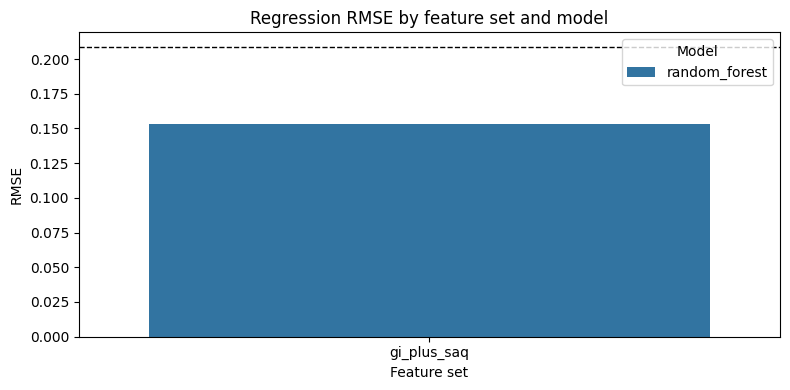

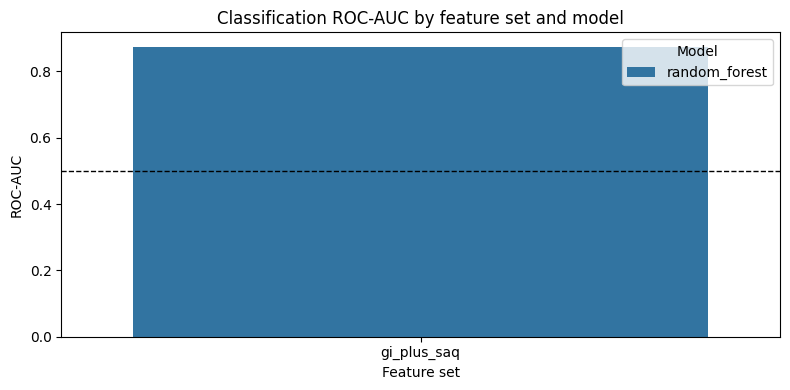

In [ ]:
# Ensure baselines and summaries exist (handle fresh kernel runs)
try:
    _ = regression_summary
    _ = classification_summary
    _ = baseline_results
except NameError:
    baseline_results = {}
    for key, bundle0 in feature_bundles.items():
        ytr, yte = bundle0["y_train_reg"], bundle0["y_test_reg"]
        ytrc, ytec = bundle0["y_train_clf"], bundle0["y_test_clf"]
        reg_pred_base = np.full_like(yte, fill_value=ytr.mean(), dtype=float)
        rmse_b = np.sqrt(mean_squared_error(yte, reg_pred_base))
        mae_b = mean_absolute_error(yte, reg_pred_base)
        maj = int(ytrc.mode()[0])
        clf_pred_base = np.full_like(ytec, fill_value=maj)
        acc_b = accuracy_score(ytec, clf_pred_base)
        try:
            auc_b = roc_auc_score(ytec, clf_pred_base)
        except ValueError:
            auc_b = 0.5
        baseline_results[key] = {"rmse": rmse_b, "mae": mae_b, "accuracy": acc_b, "roc_auc": auc_b}

    import pandas as pd
    # If full model_results_df exists, use it; otherwise synthesize from current RFs
    rows = []
    if "gi_only__regression__random_forest" in model_registry:
        pipe = model_registry["gi_only__regression__random_forest"]
        b = feature_bundles["gi_only"]
        pred = pipe.predict(b["X_test"])
        rows.append({"feature_set": "gi_only", "task": "regression", "model": "random_forest",
                     "rmse": float(np.sqrt(mean_squared_error(b["y_test_reg"], pred))),
                     "mae": float(mean_absolute_error(b["y_test_reg"], pred))})
    if "gi_plus_saq__regression__random_forest" in model_registry:
        pipe = model_registry["gi_plus_saq__regression__random_forest"]
        b = feature_bundles["gi_plus_saq"]
        pred = pipe.predict(b["X_test"])
        rows.append({"feature_set": "gi_plus_saq", "task": "regression", "model": "random_forest",
                     "rmse": float(np.sqrt(mean_squared_error(b["y_test_reg"], pred))),
                     "mae": float(mean_absolute_error(b["y_test_reg"], pred))})
    if "gi_only__classification__random_forest" in model_registry:
        pipe = model_registry["gi_only__classification__random_forest"]
        b = feature_bundles["gi_only"]
        pred = pipe.predict(b["X_test"]); proba = pipe.predict_proba(b["X_test"])[:,1]
        rows.append({"feature_set": "gi_only", "task": "classification", "model": "random_forest",
                     "accuracy": float(accuracy_score(b["y_test_clf"], pred)),
                     "roc_auc": float(roc_auc_score(b["y_test_clf"], proba))})
    if "gi_plus_saq__classification__random_forest" in model_registry:
        pipe = model_registry["gi_plus_saq__classification__random_forest"]
        b = feature_bundles["gi_plus_saq"]
        pred = pipe.predict(b["X_test"]); proba = pipe.predict_proba(b["X_test"])[:,1]
        rows.append({"feature_set": "gi_plus_saq", "task": "classification", "model": "random_forest",
                     "accuracy": float(accuracy_score(b["y_test_clf"], pred)),
                     "roc_auc": float(roc_auc_score(b["y_test_clf"], proba))})
    model_results_df = pd.DataFrame(rows)
    regression_summary = model_results_df[model_results_df["task"] == "regression"].sort_values(["feature_set", "rmse"])
    classification_summary = model_results_df[model_results_df["task"] == "classification"].sort_values(["feature_set", "roc_auc"], ascending=[True, False])

# Regression plot
reg_plot_data = regression_summary.copy()
reg_plot_data["baseline_rmse"] = reg_plot_data["feature_set"].map(lambda fs: baseline_results[fs]["rmse"])
plt.figure(figsize=(8, 4))
ax = sns.barplot(data=reg_plot_data, x="feature_set", y="rmse", hue="model")
for _, row in reg_plot_data.drop_duplicates("feature_set").iterrows():
    ax.axhline(row["baseline_rmse"], color="black", linestyle="--", linewidth=1)
ax.set_title("Regression RMSE by feature set and model")
ax.set_ylabel("RMSE")
ax.set_xlabel("Feature set")
ax.legend(title="Model")
plt.tight_layout()
plt.show()

# Classification plot
clf_plot_data = classification_summary.copy()
clf_plot_data["baseline_auc"] = clf_plot_data["feature_set"].map(lambda fs: baseline_results[fs]["roc_auc"])
plt.figure(figsize=(8, 4))
ax = sns.barplot(data=clf_plot_data, x="feature_set", y="roc_auc", hue="model")
for _, row in clf_plot_data.drop_duplicates("feature_set").iterrows():
    ax.axhline(row["baseline_auc"], color="black", linestyle="--", linewidth=1)
ax.set_title("Classification ROC-AUC by feature set and model")
ax.set_ylabel("ROC-AUC")
ax.set_xlabel("Feature set")
ax.legend(title="Model")
plt.tight_layout()
plt.show()

